# Import library

In [298]:
from pyspark.sql.types import StructType, StructField, IntegerType,\
LongType, FloatType, StringType, BooleanType, DateType
import pyspark.sql.functions as psf
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator

import mlflow

import re
from functools import partial
import shap
import pandas as pd

# single machine ml
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
 
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, SparkTrials, Trials, STATUS_FAIL

# Import custom libs
import config
import crm_schema
import utils
import utilit_model_report as UMR
import utilities_am as ut_ANDREY_v2


import importlib
importlib.reload(config)
importlib.reload(crm_schema)
importlib.reload(utils)

# lgb.cv = utils.cv_changed

<module 'utils' from '/home/IT_BI/git/spark-ml-labs/lgbm/utils.py'>

# Load data

In [2]:
# Initialize spark session
spark = (
    SparkSession
    .builder
    .appName("crm modelling")
    .getOrCreate()
)

In [3]:
input_data_file = "MODELLING_DATA_SUB.csv" 
sdf_raw = spark.read.csv(input_data_file, header=True, schema=crm_schema.input_data_schema)

In [4]:
sdf_raw.limit(5).toPandas().head()

,ID_CUID,EFFECTIVE_DATE,REPORT_DATE,RUN_DATE,CA_START_DT,CA_OFFER_TYPE_CODE,CA_F_CLX_ELIGIBLE,CA_LIMIT_OF,CA_MAXINST_OF,CA_RBP_OF,...,PCB_CNT_CLX_LOAN,PCB_CNT_CLX_NON_HOME_LOAN,PCB_BALANCE_VOL_REMAINING,PCB_CNT_TENOR_REMAINING,PCB_AVG_SCORE,SC_GR,FLAG_SIGN_WO_CANCEL,FLAG_BEFORE_REPORT,FLAG_CAL_CONTRACT_SIGNED_1M,FLAG_CCX_CONTRACT_SIGNED_1M
0,6160752,2020-05-14,2019-08-01,2020-05-14,2019-07-26,NaN,1,17338116.0,1015092.0,RBP 03,...,0,0,NaN,NaN,NaN,OC3Y,1,1,0,0
1,8228212,2020-05-14,2019-08-01,2020-05-14,2019-07-25,NaN,1,11000000.0,2598660.0,RBP 03,...,0,0,0.0,0.0,506.0,MFLC_12,1,1,0,0
2,12744249,2020-05-14,2019-08-01,2020-05-14,2019-07-10,NaN,1,200000000.0,11914759.0,RBP 01,...,0,0,NaN,NaN,0.0,MFLC_05,1,1,0,0
3,10409324,2020-05-14,2019-08-01,2020-05-14,2019-07-17,NaN,1,12000000.0,2096486.0,RBP 05,...,0,0,NaN,NaN,NaN,OC2Y,1,1,0,0
4,10218197,2020-05-14,2019-08-01,2020-05-14,2019-07-12,NaN,1,15000000.0,2323125.0,RBP 03,...,0,0,0.0,0.0,494.0,OC2Y,1,1,0,0


# Pre-processing data

In [5]:
#give a unique name to your model, all files created in process of modelling will have names ended on the unique_name
unique_name = '_cl'

#predictors from ADM to use
pred_cols = config.pred_cols

#preprocessing
cols_to_drop = []
cols_to_log = []
cols_to_fix = {}

## Label encoding

In [6]:
# Get attributes with object type (category)
cat_cols = []
for col, typo in sdf_raw.dtypes:
    if typo in ("string"):
        cat_cols.append(col)
    elif re.search(".*SK.?_",col) is not None:
        cat_cols.append(col)

# Fill in na with -1
# Upper case for the values
sdf_pre_processed = sdf_raw.fillna(-1)
for col in cat_cols:
    sdf_pre_processed = sdf_pre_processed.withColumn(col, psf.upper(psf.col(col)))

# Generate new DF with label encoding
# Keep null values
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(sdf_pre_processed) \
            for column in list(cat_cols)]
pipeline = Pipeline(stages=indexers)
sdf_pre_processed = pipeline.fit(sdf_pre_processed).transform(sdf_pre_processed)

# Drop cat cols & rename index cols
for col in cat_cols:
    sdf_pre_processed = (sdf_pre_processed
                         .drop(col)
                        .withColumnRenamed(col+"_index", col)
                        )
# checking if we didn't lose any field while preprocessing data (compare the intial and preprocessed data sets)
print(f"""
# len(pred_cols) = {len(pred_cols)}
# len(sdf_raw.columns) = {len(sdf_raw.columns)}
# len(set(sdf_raw.columns) & set(pred_cols) = {len(set(sdf_raw.columns) & set(pred_cols))}
""")

# Excluding pre_cols that have repeated values with frequency > 0.9999
total_rows = sdf_pre_processed.count()
const_cols = []
not_const_cols = []
for col in pred_cols:
    value_count = (sdf_pre_processed
            .groupby(col)
            .agg(psf.count(col).alias(col + "_count"))
            .orderBy(col + "_count", ascending=False)
            .take(1)
           )[0][1]
    if value_count/total_rows >= 0.9999:
        const_cols.append(col)
    else:
        not_const_cols.append(col)
print(f"Columns to drop: {const_cols}")

# Extract cols used for prediction and not having constant values (>99.99%)
IND_NAME = 'FLAG_CAL_CONTRACT_SIGNED_1M' # target
sdf_pre_processed = sdf_pre_processed.select(not_const_cols + [IND_NAME])
print(f"# len(sdf_pre_processed.columns) = {len(sdf_pre_processed.columns)}")

print("Check target column stats")
sdf_pre_processed.describe(IND_NAME).show()

# Shuffle zeros values of target attribute by cutting of 600,000 records
sdf_zeros_shuffle = sdf_pre_processed.filter(f"{IND_NAME} = 0").orderBy(psf.rand()).limit(600000)
sdf_ones = sdf_pre_processed.filter(f"{IND_NAME} = 1")
sdf_oversample = sdf_ones.union(sdf_zeros_shuffle)


# len(pred_cols) = 170
# len(sdf_raw.columns) = 191
# len(set(sdf_raw.columns) & set(pred_cols) = 170

Columns to drop: ['CA_OFFER_TYPE_CODE', 'CA_F_CLX_ELIGIBLE', 'TR_F_FIRST_TRAN_1M', 'CNT_WEB_APP_MONTHS_OFFER_TAB']
# len(sdf_pre_processed.columns) = 167
Check target column stats
+-------+---------------------------+
|summary|FLAG_CAL_CONTRACT_SIGNED_1M|
+-------+---------------------------+
|  count|                     100000|
|   mean|                    0.00625|
| stddev|        0.07880989538120271|
|    min|                          0|
|    max|                          1|
+-------+---------------------------+



# Process modelling

In [7]:
# Store sdf_oversample to hdfs
processed_data_path = "data/processed_data.parquet"
sdf_oversample.write.parquet(processed_data_path, mode="overwrite")

In [8]:
sdf_train, sdf_test = sdf_oversample.randomSplit([0.7, 0.3], seed=42)
print(f"""There are {sdf_train.count()} rows in the training set, and {sdf_test.count()} in the test set""")

There are 69994 rows in the training set, and 30006 in the test set


In [10]:
sdf_test.select("*").limit(5).toPandas().head()

,CA_LIMIT_OF,CA_MAXINST_OF,CA_RBP_OF,CA_PROD_PRI_GR,CA_TENOR_MAX,CA_TENOR_MIN,APL_F_CL_BOD01_1M,APL_F_CL_BOD02_1M,APL_F_CL_APPROVE_1M,APL_F_CL_SIGN_1M,...,PCB_CNT_HIST_NON_HOME_CONTRACT,PCB_CNT_CLX_LOAN,PCB_CNT_CLX_NON_HOME_LOAN,PCB_BALANCE_VOL_REMAINING,PCB_CNT_TENOR_REMAINING,PCB_AVG_SCORE,PMT_CNT_TOTAL,PMT_MAX_AMT,PMT_AVG_AMT,FLAG_CAL_CONTRACT_SIGNED_1M
0,6000000.0,1272864.0,2.0,5.0,6000000.0,5000000.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,-1.0,-1.0,0.0,4,1099000.0,1098250.0,1
1,6000000.0,1355407.0,2.0,5.0,6000000.0,5000000.0,-1.0,-1.0,-1.0,-1.0,...,1,0,0,0.0,0.0,464.0,14,848000.0,588571.0,1
2,6000000.0,1995724.0,2.0,5.0,6000000.0,5000000.0,-1.0,-1.0,-1.0,-1.0,...,4,3,3,37546504.0,16.0,450.0,4,887000.0,886250.0,1
3,11031251.0,786010.0,1.0,0.0,20000000.0,5000000.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,-1.0,-1.0,0.0,5,749000.0,749000.0,1
4,12000000.0,1844100.0,1.0,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,682000.0,1.0,449.0,10,683000.0,648900.0,1


In [11]:
a = {"key": 0.1}

# Find the best parameters
http://hyperopt.github.io/hyperopt/scaleout/spark/

* How to use hyperopt with SparkTrials: https://docs.databricks.com/applications/machine-learning/automl-hyperparam-tuning/hyperopt-spark-mlflow-integration.html#how-to-use-hyperopt-with-sparktrials
* Best practice: https://docs.databricks.com/applications/machine-learning/automl-hyperparam-tuning/hyperopt-best-practices.html
    

In [12]:
pdf_oversample = sdf_oversample.toPandas()

In [14]:
X_train, X_val, y_train, y_val = train_test_split( pdf_oversample.drop([IND_NAME],axis=1)
                                                    , pdf_oversample[IND_NAME]
                                                    , test_size=0.3, stratify=pdf_oversample[IND_NAME]
                                                    , random_state=7)

print ('Mean target: ', pdf_oversample[IND_NAME].mean())
print ('Train', (X_train.shape, y_train.mean(), y_train.sum()))
print ('Valid', (X_val.shape, y_val.mean(), y_val.sum()))

Mean target:  0.00625
Train ((70000, 166), 0.006242857142857143, 437)
Valid ((30000, 166), 0.006266666666666667, 188)


In [228]:
def load_data(input_data_path, cat_cols, target_col = IND_NAME):
    spark = (
                SparkSession
                .builder
                .appName("hyperparam tunning")
                .getOrCreate()
            )
    
    pdf_data = spark.read.parquet(input_data_path).toPandas()

    # Split train & validation dataset
    X_train, X_val, y_train, y_val = train_test_split(
        pdf_data.drop([target_col],axis=1), # X dataset
        pdf_data[target_col], # y target
        test_size=0.3,
        stratify=pdf_data[target_col],
        random_state=7
    )

    # Get cateogry column location
    cat_feats = get_cat_col_idx(cat_cols, pdf_data)

    return  X_train.reset_index(drop=True),\
            X_val.reset_index(drop=True),\
            Y_train.reset_index(drop=True),\
            Y_val.reset_index(drop=True), \
            cat_feats


# functions for creating model and selection of hyperparameters
# def objective_lgb(space, input_data_path, cat_cols):
def objective_lgb(space, pdf_data, cat_cols):
    target_col = IND_NAME
    NFALG_PRINT_HIST = True
    NUM_FOLDS = 3
    tp = type(target_col)

#     X_train, X_val, y_train, y_val, cat_feats = load_data(input_data_path, cat_cols)
    # Split train & validation dataset
    X_train, X_val, y_train, y_val = train_test_split(
        pdf_data.drop([target_col], axis=1), # X dataset
        pdf_data[target_col], # y target
        test_size=0.3,
        stratify=pdf_data[target_col],
        random_state=7
    )
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    # Get cateogry column location
    cat_feats = get_cat_col_idx(cat_cols, pdf_data)
    
    # TODO: remove if no needed?
    #global iteration, best_auc_so_far, best_ntrees
#     global iteration, best_auc_val_so_far, best_auc_val_std_so_far, best_ntrees, best_auc_train_so_far, best_auc_train_std_so_far
#     iteration += 1
    
    params = {'num_leaves': int(space['num_leaves']),
              'min_data_in_leaf': int(space['min_data_in_leaf']),
              'max_depth': int(space['max_depth']),
              'bagging_freq': int(space['bagging_freq']),
              'max_bin': int(space['max_bin']),
              'learning_rate': space['learning_rate'], 
              'feature_fraction': space['feature_fraction'],             
              'bagging_fraction': space['bagging_fraction'],
              'n_jobs': space['n_jobs'],
              'objective': space['objective'],
              'random_state': space['random_state']
             }

    ds = lgb.Dataset(X_train,
                     y_train,
                     categorical_feature=cat_feats)
    
    cv_res = utils.cv_changed(params,
                    ds,
                    metrics='auc',
                    num_boost_round=1000,
                    early_stopping_rounds=50,
                    nfold=NUM_FOLDS,
                    folds=None,
                    categorical_feature=cat_feats)
#     import json
#     import random
#     dmp_file = "data/cv_res_" + str(random.randint(0,100))
#     with open(dmp_file,"w") as f:
#         f.write(json.dumps(cv_res))
        
#     try:
#         print(cv_res['auc-val-mean'][-1])
# #         pass
#     except Exception as e:
#         return {'exception': e, 'status': STATUS_OK }
    
    
    auc_val = cv_res['auc-val-mean'][-1]  #AUC  for the last boosting of Validation sample
    auc_val_std = cv_res['auc-val-stdv'][-1] #AUC STD for the last boosting of Validation sample
    auc_train = cv_res['auc-train-mean'][-1]  #AUC for the last boosting of Training Sample
    auc_train_std = cv_res['auc-train-stdv'][-1] #AUC STD for the last boosting of Training Sample
    
    # choosing best parameters based on a comparison between a new calculated and the last best
#     if (((auc_val-2*auc_val_std)-0.5*abs((auc_train)-(auc_val))) > 
#         ((best_auc_val_so_far - best_auc_val_std_so_far)-
#          0.5*abs((best_auc_train_so_far)-(best_auc_val_so_far)))):
#         best_auc_val_so_far = auc_val
#         best_auc_val_std_so_far = auc_val_std
#         best_ntrees = len(cv_res['auc-val-mean'])
#         best_auc_train_so_far = auc_train
#         best_auc_train_std_so_far = auc_train_std

#     if NFALG_PRINT_HIST:
#         print('iteration {}'.format(iteration))
#         print("---AUC SCORE (val):\t{} (std: {}) ({} (std: {}) best so far)".format(round(auc_val,6), round(auc_val_std,6), 
#                                                                                     round(best_auc_val_so_far,6), round(best_auc_val_std_so_far,6)))
#         print("---AUC SCORE (train):\t{} (std: {}) ({} (std: {}) best so far)".format(round(auc_train,6), round(auc_train_std,6), 
#                                                                                       round(best_auc_train_so_far,6), round(best_auc_train_std_so_far,6)))
#         print("---ntrees:\t{} ({} best so far)\n".format(len(cv_res['auc-val-mean']), best_ntrees))
    
    loss = 1-((auc_val - auc_val_std)-0.5*abs((auc_train + auc_train_std)-(auc_val - auc_val_std)))
    
    return {'loss': loss, 'status': STATUS_OK }


In [291]:
def objective_lgb(space, X_train, y_train, cat_feats):
    """
    Objective funtion to return loss back to hyperopt operation to get the best params which produce smallest loss
    """
    
    params = {
          "num_leaves": int(space["num_leaves"]),
          "min_data_in_leaf": int(space["min_data_in_leaf"]),
          "max_depth": int(space["max_depth"]),
          "bagging_freq": int(space["bagging_freq"]),
          "max_bin": int(space["max_bin"]),
          "learning_rate": space["learning_rate"], 
          "feature_fraction": space["feature_fraction"],             
          "bagging_fraction": space["bagging_fraction"],
          "n_jobs": space["n_jobs"],
          "objective": space["objective"],
          "random_state": space["random_state"]
         }

    ds = lgb.Dataset(X_train,
                     y_train,
                     categorical_feature=cat_feats)
    
    cv_res = utils.cv_changed(params,
                    ds,
                    metrics="auc",
                    num_boost_round=1000,
                    early_stopping_rounds=50,
                    nfold=3,
                    folds=None,
                    categorical_feature=cat_feats)
    
    # Todo: get best_ntrees
    auc_val = cv_res["auc-val-mean"][-1]  #AUC  for the last boosting of Validation sample
    auc_val_std = cv_res["auc-val-stdv"][-1] #AUC STD for the last boosting of Validation sample
    auc_train = cv_res["auc-train-mean"][-1]  #AUC for the last boosting of Training Sample
    auc_train_std = cv_res["auc-train-stdv"][-1] #AUC STD for the last boosting of Training Sample
    
    loss = 1-((auc_val - auc_val_std)-0.5*abs((auc_train + auc_train_std)-(auc_val - auc_val_std)))
    
    return {"loss": loss, "status": STATUS_OK }
    
def tune_params(objective, params_space, X_train, y_train, cat_feats, evals, n_workers):
    space = {
         "num_leaves" : hp.choice("num_leaves", params_space["num_leaves"]),
         "min_data_in_leaf" : hp.choice("min_data_in_leaf", params_space["min_data_in_leaf"]),
         "max_depth" : hp.choice("max_depth", params_space["max_depth"]),
         "bagging_freq" : hp.choice("bagging_freq", params_space["bagging_freq"]),
         "max_bin" : hp.choice("max_bin", params_space["max_bin"]),             

         "learning_rate" : hp.choice("learning_rate", params_space["learning_rate"]),
         "feature_fraction" : hp.choice("feature_fraction", params_space["feature_fraction"]),
         "bagging_fraction" : hp.choice("bagging_fraction", params_space["bagging_fraction"]),
         "n_jobs" : hp.choice("n_jobs", params_space["n_jobs"]),
         "objective" : hp.choice("objective", params_space["objective"]),
         "random_state" : hp.choice("random_state", params_space["random_state"])
    }

    best_params = fmin(
                    fn=partial(
                        objective, 
                        X_train=X_train, 
                        y_train=y_train, 
                        cat_feats=cat_feats
                    ),
                    space=space,
                    algo=tpe.suggest,
                    max_evals=evals,  # number of iterations
                    trials=SparkTrials(parallelism=n_workers)
                  )

    for k in params_space.keys():
        best_params[k] = params_space[k][best_params[k]]

    return best_params

def get_cat_col_idx(cat_cols, pdf):
    """
    Get the indice of categorical columns.
    """
    res = []
    for i in range(len(pdf.columns)):
        if pdf.columns[i] in cat_cols:
            res.append(i)
    return res

def get_prepared_data(pdf, get_train_ds_only = True, target_col=IND_NAME, test_size=0.3, random_state=7):
    """
    Split input data into train and test dataset.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        pdf.drop([target_col], axis=1),
        pdf[target_col],
        test_size=test_size,
        stratify=pdf[target_col],
        random_state=random_state
    )
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    if get_train_ds_only:
        return X_train, y_train
    else:
        X_test = X_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)
        return X_train, X_test, y_train, y_test

def validate_lgbm_model(best_params, X_train, X_test, y_train, y_test, cat_feats, best_ntrees):
    """
    Run this function to see the auc scoring on test dataset
    """
    train = lgb.Dataset(X_train, y_train, categorical_feature=cat_feats)
    test = lgb.Dataset(X_test, y_test, categorical_feature=cat_feats)
    
    booster = lgb.train(
        best_params,
        train_set=train,
        valid_sets=[train, test],
        categorical_feature=cat_feats,
        num_boost_round=best_ntrees,
        verbose_eval=True
    )
    
    y_pred_train = booster.predict(X_train)
    y_pred_val = booster.predict(X_test)
    
    print("roc auc score on train: ", roc_auc_score(Y_train, y_pred_train))
    print("roc auc score on val: ", roc_auc_score(Y_val, y_pred_val))
    
    #model performance visualization (using a Russian library)
    ut_ANDREY_v2.print_lift_roc_pr_plot(y_test, y_pred_val,NAME_MODEL="val")
    ut_ANDREY_v2.print_lift_roc_pr_plot(y_train, y_pred_train,NAME_MODEL="train")
    
    return booster

100%|██████████| 5/5 [00:24<00:00,  4.87s/trial, best loss: 0.23475196358327555]


Total Trials: 5: 5 succeeded, 0 failed, 0 cancelled.


[1]	training's binary_logloss: 0.0374698	valid_1's binary_logloss: 0.0376405
[2]	training's binary_logloss: 0.0373141	valid_1's binary_logloss: 0.0374922
[3]	training's binary_logloss: 0.0371804	valid_1's binary_logloss: 0.0373742
roc auc score on train:  0.654240952614575
roc auc score on val:  0.6554627081483682
val
        k  lift_cumulative  precision     tp  num_samples  threshold
0     1.0        13.829787   0.086667   26.0        300.0   0.007673
1     5.0         6.276596   0.039333   59.0       1500.0   0.006723
2    10.0         3.989362   0.025000   75.0       3000.0   0.006188
3    20.0         2.260638   0.014167   85.0       6000.0   0.006188
4    30.0         1.719858   0.010778   97.0       9000.0   0.006188
5    40.0         1.462766   0.009167  110.0      12000.0   0.006188
6    50.0         1.276596   0.008000  120.0      15000.0   0.006188
7    60.0         1.161348   0.007278  131.0      18000.0   0.006188
8    70.0         1.101824   0.006905  145.0      21000.0  

/home/IT_BI/git/spark-ml-labs/lgbm/utilities_am.py:427: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  __plt.subplot(321)
/home/IT_BI/git/spark-ml-labs/lgbm/utilities_am.py:444: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  __plt.subplot(322)
/home/IT_BI/git/spark-ml-labs/lgbm/utilities_am.py:457: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

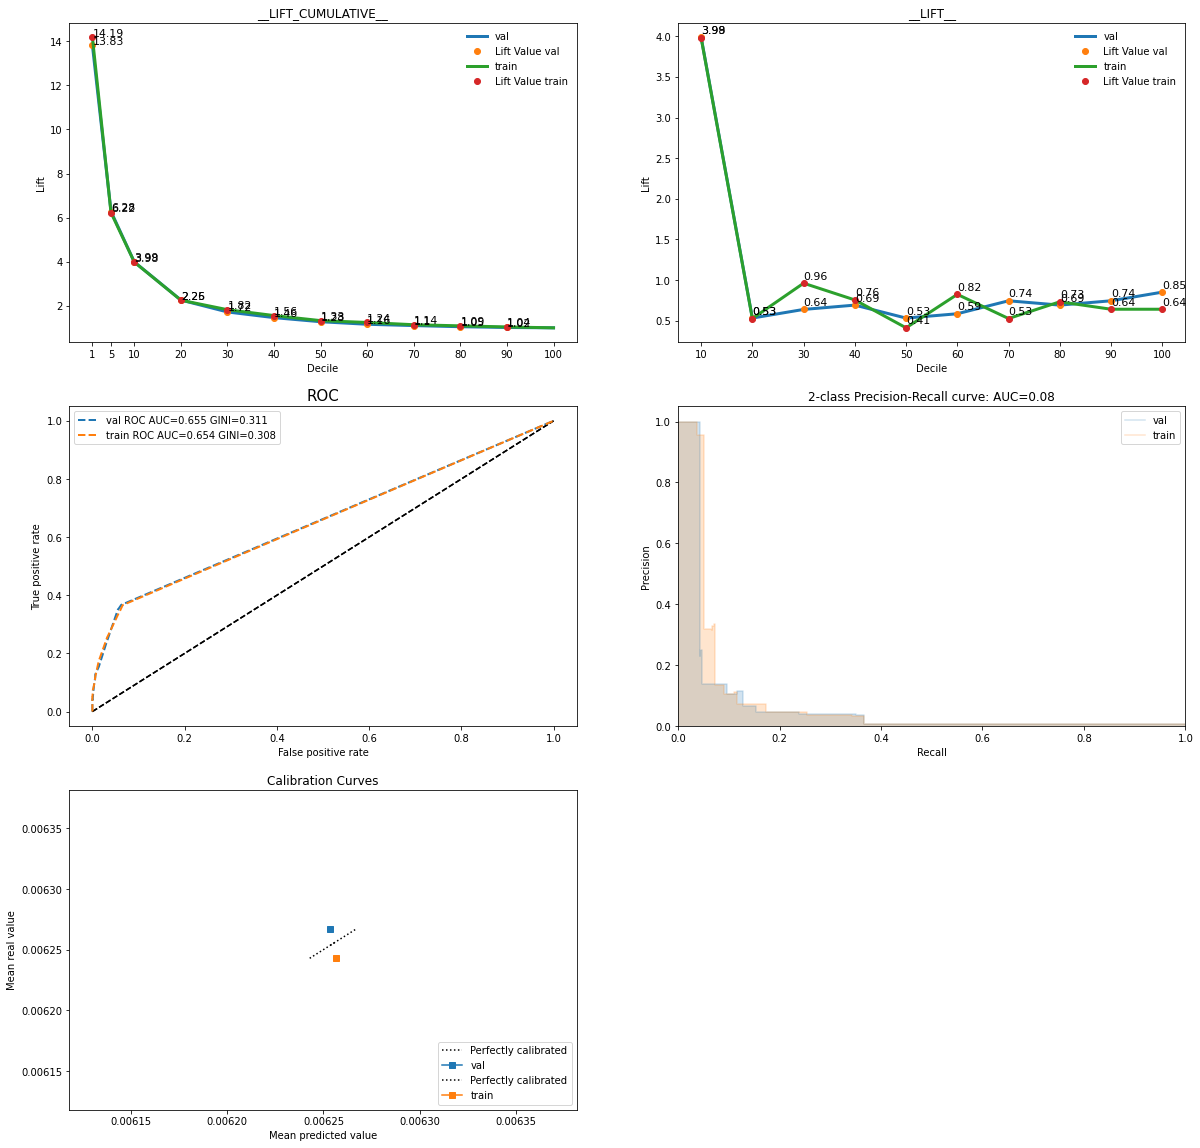

In [292]:
params_space = {
    "num_leaves":[4, 12, 50, 100, 150, 200],
    "min_data_in_leaf":[20, 50, 100, 250],
    "max_depth":[2, 4, 6],
    "bagging_freq":[1, 2, 3, 5, 10],
    "max_bin":[100, 255, 500],

    "learning_rate":[.01, .05, .1, .3, .5, .8],
    "feature_fraction":[.25, .3, .5, .7],
    "bagging_fraction":[.3, .5, .7],
    "n_jobs": [8],
    "objective": ["binary"], 
    "random_state": [123]
}

cat_feats = get_cat_col_idx(cat_cols, pdf_oversample)
X_train, X_test, y_train, y_test = get_prepared_data(pdf_oversample, get_train_ds_only = False)
best_params = tune_params(objective_lgb, params_space, X_train, y_train, cat_feats, evals=5, n_workers=3)
booster = validate_lgbm_model(best_params, X_train, X_test, y_train, y_test, cat_feats, best_ntrees=3)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


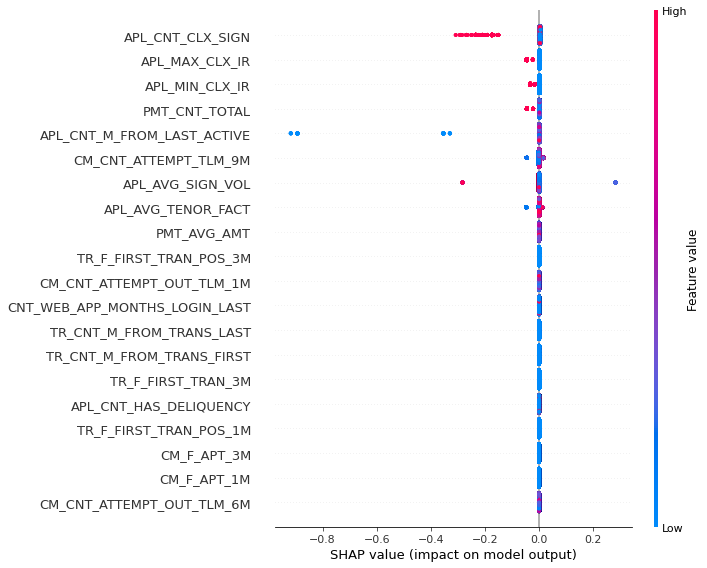

In [299]:
# Preparations to show most important features
shap.initjs()
model = booster
X = pd.DataFrame(X_train)
count_show_features = 20

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[0], X, max_display=count_show_features)